<a href="https://colab.research.google.com/github/pkaramertzanis/modelling_hazard_assessment/blob/master/notebooks/01_lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 1 - Modelling and computation in hazard assessment**

There are two lab days;

* Lab 1: 26 February 2025
* Lab 2: 27 February 2025

We will start with Lab 1 that introduces fundamental data analysis and modelling concepts that will be demostrated in the lectures of the Computation and Modelling in Hazard Assessment training.

*   First we will prepare our computer, load in the data and perform some initial explorative analysis to get an impression of the data we have at hand. We will use *in vitro* genotoxocity data and explore it by creating some illustrative visualisations.

* Then we will convert some of our data. The algorithm that we would like to design requires a different kind of data format compared to the data at hand, hence we need to convert the current data into a format that is accepted by the algorithm. We will convert molecular structures to morgan finger prints.

*   Finally, we'll develop our first neural network model to model genotoxicity using a classification model

Note: This training is using a public computing platform and hence all data are not proprietary, not confidential and not subject to IPR restrictions. Still, the dataset has not been openly shared as this would require the inclusion of the relevant terms and conditions of the applicable licences. Be aware with using confidential data in public computing platforms and do not share this datase further.

## Environment setup

Firstly, let's install packages that are needed later in the tutorial and that are not natively available in google colab.

In [112]:
# install the necessary packages that are not preinstalled in google colab
!pip install rdkit
!pip install tqdm

In [2]:
# check versions of dependencies
import sys
from packaging.version import Version, InvalidVersion

def get_packages(pkgs):
  versions = []
  for p in pkgs:
    try:
      imported = __import__(p)
      try:
        versions.append(imported.__version__)
      except AttributeError:
        try:
          versions.append(imported.version)
        except AttributeError:
          try:
            versions.append(imported.version_info)
          except AttributeError:
            versions.append('0.0')
    except ImportError:
      print(f'[FAIL]: {p} is not installed and/or cannot be imported.')
      versions.append('N/A')
  return versions

print(f"python: {sys.version}")
pkgs = ['torch', 'numpy', 'pandas', 'sklearn', 'rdkit', 'matplotlib', 'seaborn']
version = get_packages(pkgs)
for pkg, version in zip(pkgs, version):
  print(f"{pkg}: {version}")

python: 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
torch: 2.5.1+cu121
numpy: 1.26.4
pandas: 2.2.2
sklearn: 1.6.0
rdkit: 2024.09.4
matplotlib: 3.8.0
seaborn: 0.13.2


In [113]:
# import libraries (locally needed depedendencies will be imported when needed)
import numpy as np
import pandas as pd
import requests
from pathlib import Path
import time
from tqdm.notebook import tqdm
from rdkit import Chem                        #cheminformatics
from rdkit.Chem import AllChem                #cheminformatics
from rdkit.Chem import Draw                   #cheminformatics
from rdkit.Chem.Draw import rdMolDraw2D       #cheminformatics
from rdkit.Chem.Draw import IPythonConsole    #cheminformatics
import torch                                  #modelling
import torch.nn.functional as F               #modelling
from torch.utils.data import TensorDataset    #modelling
from torch.utils.data import DataLoader       #modelling
from sklearn.model_selection import train_test_split  #modelling
from sklearn.metrics import roc_auc_score             #modelling
from sklearn.metrics import balanced_accuracy_score   #modelling
from sklearn.metrics import recall_score              #modelling
import matplotlib.pyplot as plt               #visualisation
import seaborn as sns                         #visualisation
%matplotlib inline

In [114]:
# enable progress bar for the pandas.apply
tqdm.pandas()

In [5]:
# setup pandas
pd.set_option('expand_frame_repr', False)
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 100)
pd.set_option("display.precision",3)
pd.set_option("max_colwidth", 250)
pd.options.mode.copy_on_write = True

In [115]:
# mount the google drive in case we wish to persist results, this cell is not necessary for the remaining of the Lab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset preparation

### Load the dataset

The dataset we will be using has been stored in the Github repository that was set up for this training. It will be fetched and stored in the space that is is temporarily created when the runtime environment is started.

In [147]:
# fetch the dataset from the github repository
import requests
from getpass import getpass

# Provide your GitHub credentials (will be removed when the repository becomes public)
token = getpass("Enter your GitHub token: ")

# Set up the file URL
file_url = "https://raw.githubusercontent.com/pkaramertzanis/modelling_hazard_assessment/master/datasets/genotoxicity_dataset.xlsx"  # Updated URL

# Use the token for authentication
headers = {'Authorization': f'token {token}'}
response = requests.get(file_url, headers=headers)

# Save the file locally
if response.status_code == 200:
    with open(Path(file_url).name, "wb") as file:
        file.write(response.content)
    print("File downloaded successfully!")
else:
    print(f"Failed to download file: {response.status_code}")

Enter your GitHub token: ··········
File downloaded successfully!


### Exploratory data analysis

What is exploratory data analysis?

Exploratory Data Analysis or (EDA) is all about inspecting the dataset. This is necessary for
- deciding which datapoints to exclude, e.g. because of missing values or duplicates
- exploring the available features and thinking which of these may be useful to include in the model with or without transformations (feature engineering)

How is exploratory data analysis done?

There is no single way for doing exploratory data analysis. Typically one starts with simple filters and aggragegations with a data analysis tool such as pandas, and continues with visualisations, such as histograms, boxplots and heatmaps using matplotlib or seaborn.

There is no such thing like a complete exploratory data analysis. There is also no recipe. Often exploratory data analysis is a continuous process and may even continue after the first models have been developed and their results examined. Unexpected model results can often lead to more exploratory data analysis to understand what is causing these unexpected predictions, followed by additional filtering, feature transformations and one more round of model fitting.

What data are we exploring today?

For the purposes of this course we will be using a genotoxicity dataset that has been created for the purposes of this course. Genotoxicity is an important endpoint under REACH. Despite its elaborate ITS based on a cascade of in vitro and in vivo tests and several years of dossier evaluation, it is still relatively uncommon to regulate substances solely on the basis of their genotoxicity properties (see https://doi.org/10.1016/j.yrtph.2019.05.003). ECHA could use the data it has to support these discussions and the subsequent policy making. For the purposes of this tutorial we will be using a dataset with Ames test results compiled through the work of the ECHA muta expert group. Let's see what this dataset is all about!



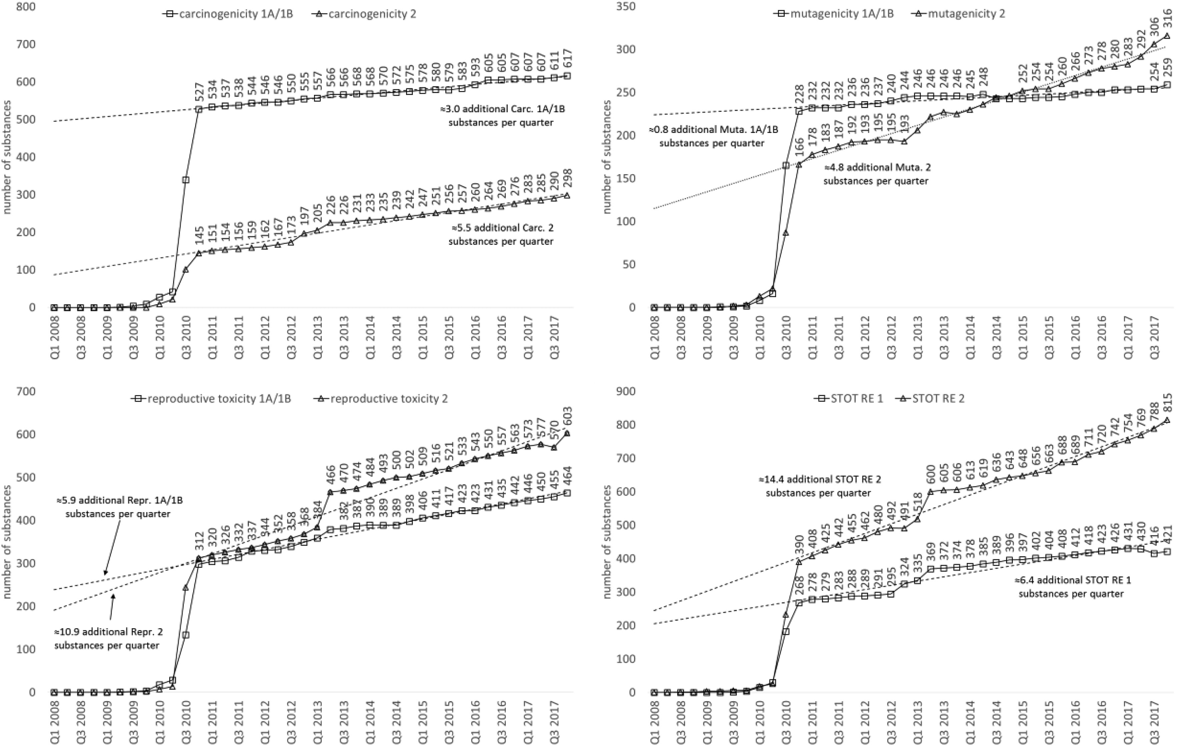

In [28]:
# The figure below is from https://doi.org/10.1016/j.yrtph.2019.05.003 cited above
from PIL import Image
from io import BytesIO
from IPython.display import display
import requests
import math
url = 'https://ars.els-cdn.com/content/image/1-s2.0-S0273230019301254-gr3_lrg.jpg'
im = Image.open(BytesIO(requests.get(url).content))
im.info = {}
new_width = math.ceil(im.width / 3)
new_height = math.ceil(im.height / 3)
im_resized = im.resize((new_width, new_height))
display(im_resized)

In [148]:
# load the dataset into a pandas dataframe
gentox_data = pd.read_excel('genotoxicity_dataset.xlsx')
print('there are {} records in the dataset.'.format(len(gentox_data)))
gentox_data.head(n=5) # display the first 5 rows

there are 27488 records in the dataset.


,datapoint ID,smiles_std,genotoxicity,endpoint
0,8,BrC(Br)Br,positive,"Salmonella typhimurium (TA 100), no"
1,10,BrC(Br)Br,negative,"Salmonella typhimurium (TA 1535), no"
2,11,BrC(Br)Br,ambiguous,"Salmonella typhimurium (TA 98), no"
3,13,BrC(Br)C(Br)Br,negative,"Salmonella typhimurium (TA 100), no"
4,14,BrC(Br)C(Br)Br,negative,"Salmonella typhimurium (TA 100), yes"


In [30]:
gentox_data.tail(n=5) # display the last 5 rows

,datapoint ID,smiles_std,genotoxicity,endpoint
27483,53856,c1nc[nH]n1,negative,"Salmonella typhimurium (TA 1535), yes"
27484,53857,c1nc[nH]n1,negative,"Salmonella typhimurium (TA 1537), no"
27485,53858,c1nc[nH]n1,negative,"Salmonella typhimurium (TA 1537), yes"
27486,53859,c1nc[nH]n1,negative,"Salmonella typhimurium (TA 98), no"
27487,53860,c1nc[nH]n1,negative,"Salmonella typhimurium (TA 98), yes"


#### Data types
The different columns can be of different types, such as floats, integers, strings, datetime, objects or other.

In [31]:
gentox_data.dtypes

,0
datapoint ID,int64
smiles_std,object
genotoxicity,object
endpoint,object


The dataset only contains 4 columns, a datapoint ID, the structure as a smiles string, the genotoxicity outcome as a string and the endpoint, which in our case is simply the bacterial strain and metabolic activation status. Hence, there is no need to drop any column as all of them are relevant for our modelling.

Although we could use the smiles as a structure ID it may be more convenient to generate one more column with the molecule ID being an integer. For each unique smiles we will assign a different molecule ID.

In [32]:
# create a molecule ID column
codes, uniques = pd.factorize(gentox_data['smiles_std'])
gentox_data.insert(loc=1, column='molecule ID', value=codes)
gentox_data

,datapoint ID,molecule ID,smiles_std,genotoxicity,endpoint
0,8,0,BrC(Br)Br,positive,"Salmonella typhimurium (TA 100), no"
1,10,0,BrC(Br)Br,negative,"Salmonella typhimurium (TA 1535), no"
2,11,0,BrC(Br)Br,ambiguous,"Salmonella typhimurium (TA 98), no"
3,13,1,BrC(Br)C(Br)Br,negative,"Salmonella typhimurium (TA 100), no"
4,14,1,BrC(Br)C(Br)Br,negative,"Salmonella typhimurium (TA 100), yes"
...,...,...,...,...,...
27483,53856,4244,c1nc[nH]n1,negative,"Salmonella typhimurium (TA 1535), yes"
27484,53857,4244,c1nc[nH]n1,negative,"Salmonella typhimurium (TA 1537), no"
27485,53858,4244,c1nc[nH]n1,negative,"Salmonella typhimurium (TA 1537), yes"
27486,53859,4244,c1nc[nH]n1,negative,"Salmonella typhimurium (TA 98), no"


Nice! Now we can refer to the molecule ID column when we want to locate a given molecular structure and the datapoint ID when we want to locate a given experimental measurement. Next we will examine if there are any rows with null values. Pandas offers a convenience function for this purpose.

In [33]:
gentox_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27488 entries, 0 to 27487
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   datapoint ID  27488 non-null  int64 
 1   molecule ID   27488 non-null  int64 
 2   smiles_std    27488 non-null  object
 3   genotoxicity  27488 non-null  object
 4   endpoint      27488 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.0+ MB


The dataset contains 53881 rows and there are no missing values in any of the four columns. In real life applications a dataset is rarely so tidy. This dataset has been extensively curated for the purposes of this training.

#### Counts and duplicates

Before we continue we can investigate how many structures we have, the number and type of strains and whether we have data for all strains for each and every structure.

In [34]:
# available strains and metabolic activations
gentox_data['endpoint'].drop_duplicates().sort_values(ascending=True)

,endpoint
17,"Escherichia coli (WP2 Uvr A), no"
18,"Escherichia coli (WP2 Uvr A), yes"
0,"Salmonella typhimurium (TA 100), no"
4,"Salmonella typhimurium (TA 100), yes"
1,"Salmonella typhimurium (TA 1535), no"
6,"Salmonella typhimurium (TA 1535), yes"
7,"Salmonella typhimurium (TA 1537), no"
8,"Salmonella typhimurium (TA 1537), yes"
2,"Salmonella typhimurium (TA 98), no"
16,"Salmonella typhimurium (TA 98), yes"


We have data for five strains, each with and without metabolic activation. Some of the strains may be detecting the same genotoxicity mode of action. Some of these strains may also be more predictive of gene mutation than others. Any feedback from mutagenicity experts participating in the training?

Next, we can count the number of structures and the data availability for each.

In [35]:
# number of structures
n_structures = gentox_data['smiles_std'].nunique()
print(f'There are {n_structures} unique structures in the dataset.')

There are 4245 unique structures in the dataset.


It will be very confusing if there are multiple genotoxicity outcomes for same structure and endpoint. This will confuse the models and the evaluation of their predictive performance. We can check this before we continue.

In [36]:
gentox_data[['molecule ID', 'endpoint', 'genotoxicity']].duplicated().sum()

0

#### Data availability

There are no duplicates, which means that there is no more than one genotoxicity outcome for each molecular structure and endpoing. This does not mean that we have data for the same endpoint for each structure. Lets examine this next by counting the number of endpoints per molecular structure.

In [37]:
# data availability
gentox_data.groupby('molecule ID')['endpoint'].count()

,endpoint
molecule ID,
0,3
1,6
2,8
3,10
4,8
...,...
4240,8
4241,8
4242,8


We can see that some molecular structures have data for all ten strain/metabolic activation combinations, whilst others are not so data rich. It will be interesting to visualise the data density for the whole dataset.

We can achieve this by counting the unique values of the previous count using method chaining.

In [38]:
tmp = (gentox_data.groupby('molecule ID')['endpoint']
 .count().rename('number of endpoints')
 .value_counts().rename('number of structures')
 .sort_index(ascending=False))
tmp

,number of structures
number of endpoints,
10,1319
9,7
8,1152
7,40
6,141
5,62
4,405
3,194
2,456


Perhaps it is easier to appreciate the data density by creating a barplot.

<Axes: xlabel='number of endpoints', ylabel='number of structures'>

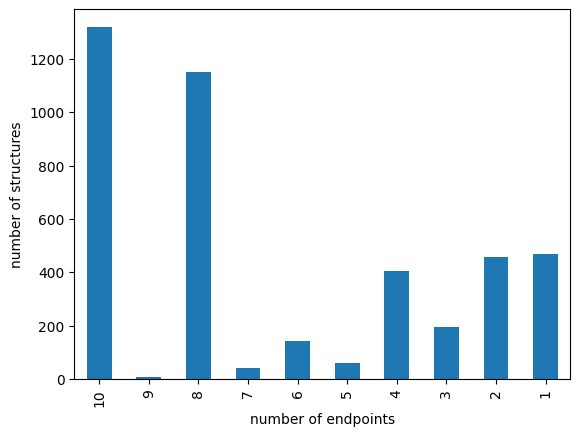

In [39]:
tmp.plot(kind='bar', ylabel='number of structures', xlabel='number of endpoints')

We can see that from the 7329 structures, approximate 2500 have data for all ten strain and metabolic activation combinations. Approximately the same number of structures have data for 8 combinations. The remaining 1/3 of the structures are less data rich.

We can also visualise the data density for each strain and metabolic activation.

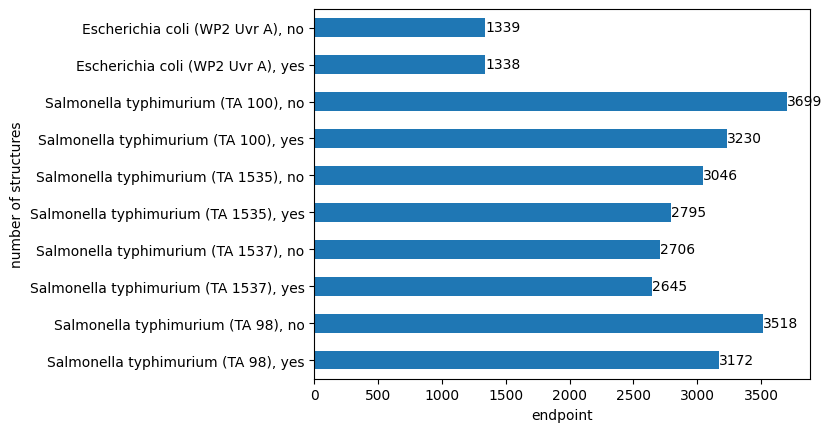

In [40]:
tmp = (gentox_data.groupby('endpoint')['molecule ID']
 .count().rename('number of structures')
 .sort_index(ascending=False))
ax = tmp.plot(kind='barh', ylabel='number of structures', xlabel='endpoint')
for p in ax.patches:
    ax.text(p.get_width(), p.get_y() + p.get_height()/2., '%d' % int(p.get_width()),
            ha='left', va='center')

The most data rich strains are TA 100 and 98. This is good news, as these strains are quite predictive for the overall Ames genotoxicity outcome.

Before we proceed with the inspection of the molecular structures and the generation of fingerprints we can examine how often we have data for endpoint pairs. We will be using a function because we will need to do this calculation more than once!

In [41]:
def create_endpoint_pair_data(df):
  endpoint_pair_data = []
  for endpoint1 in gentox_data['endpoint'].unique():
    msk1 = gentox_data['endpoint'] == endpoint1
    for endpoint2 in gentox_data['endpoint'].unique():
      msk2 = gentox_data['endpoint'] == endpoint2
      tmp = gentox_data.loc[msk1 | msk2].pivot(index='molecule ID', columns='endpoint', values='genotoxicity')
      tmp = tmp.dropna(how='any')
      endpoint_pair_data.append({'endpoint 1': endpoint1, 'endpoint 2': endpoint2, 'support': len(tmp)})
  endpoint_pair_data = pd.DataFrame(endpoint_pair_data)
  endpoint_pair_data = endpoint_pair_data.pivot(index='endpoint 1', columns='endpoint 2', values='support')
  return endpoint_pair_data
endpoint_pair_data = create_endpoint_pair_data(gentox_data)
endpoint_pair_data

endpoint 2,"Escherichia coli (WP2 Uvr A), no","Escherichia coli (WP2 Uvr A), yes","Salmonella typhimurium (TA 100), no","Salmonella typhimurium (TA 100), yes","Salmonella typhimurium (TA 1535), no","Salmonella typhimurium (TA 1535), yes","Salmonella typhimurium (TA 1537), no","Salmonella typhimurium (TA 1537), yes","Salmonella typhimurium (TA 98), no","Salmonella typhimurium (TA 98), yes"
endpoint 1,,,,,,,,,,
"Escherichia coli (WP2 Uvr A), no",1339,1336,1334,1337,1334,1333,1331,1328,1337,1336
"Escherichia coli (WP2 Uvr A), yes",1336,1338,1333,1337,1333,1333,1330,1328,1336,1336
"Salmonella typhimurium (TA 100), no",1334,1333,3699,3033,2900,2669,2624,2573,3378,2966
"Salmonella typhimurium (TA 100), yes",1337,1337,3033,3230,2665,2709,2560,2611,2949,3027
"Salmonella typhimurium (TA 1535), no",1334,1333,2900,2665,3046,2693,2640,2565,2818,2610
"Salmonella typhimurium (TA 1535), yes",1333,1333,2669,2709,2693,2795,2553,2615,2615,2659
"Salmonella typhimurium (TA 1537), no",1331,1330,2624,2560,2640,2553,2706,2564,2586,2519
"Salmonella typhimurium (TA 1537), yes",1328,1328,2573,2611,2565,2615,2564,2645,2525,2573
"Salmonella typhimurium (TA 98), no",1337,1336,3378,2949,2818,2615,2586,2525,3518,3035


We will now visualise the created `enpoint_pair_data` dataframe using a heatmap. Once more we will be using a function for this because we will need thid functionality later on.

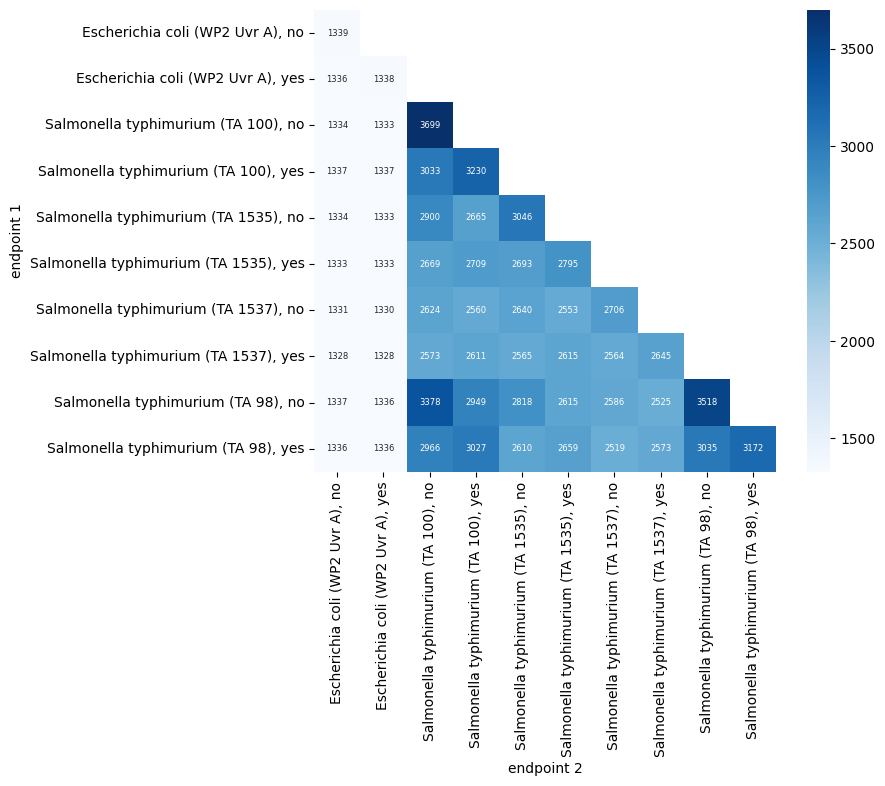

In [42]:
# visualise the simultaneous data availability for two endpoints using a heatmap
def create_heatmap(endpoint_pair_data):
  mask = np.triu(np.ones_like(endpoint_pair_data, dtype=bool), k=1)
  fig = plt.figure(figsize=(8, 6))
  ax = fig.subplots()
  sns.heatmap(endpoint_pair_data, annot=True, mask=mask, fmt='d', cmap='Blues', square=True, ax=ax, annot_kws={"fontsize": 6} )
create_heatmap(endpoint_pair_data)

The diagonal in the heatmap provides the data availability for a single endpoint and the numbers must agree with the numbers we show earlier in the barplot.

Before we conclude this section there is an important decision to take. The genotoxicity outcomes in the dataset are positive, negative and ambiguous, with the latter including both equivocal and otherwise compromised measurements (e.g. due to inappropriate cytoxicity or occurrence of precipitation).

In [43]:
gentox_data['genotoxicity'].value_counts()

,count
genotoxicity,
negative,21983
positive,5233
ambiguous,272


The number of ambiguous calls is quite small. Hence it is best to exclude them. This means that the number of labels will be reduced to two and hence the classification models will become binary rather than multiclass.

In [149]:
# exclude ambiguous genotoxicity calls
msk = gentox_data['genotoxicity'] != 'ambiguous'
gentox_data = gentox_data[msk]
gentox_data['genotoxicity'].value_counts()

,count
genotoxicity,
negative,21983
positive,5233


Let's create the heatmap once more to visualise the reduction in terms of number of structures for each endpoint combination.

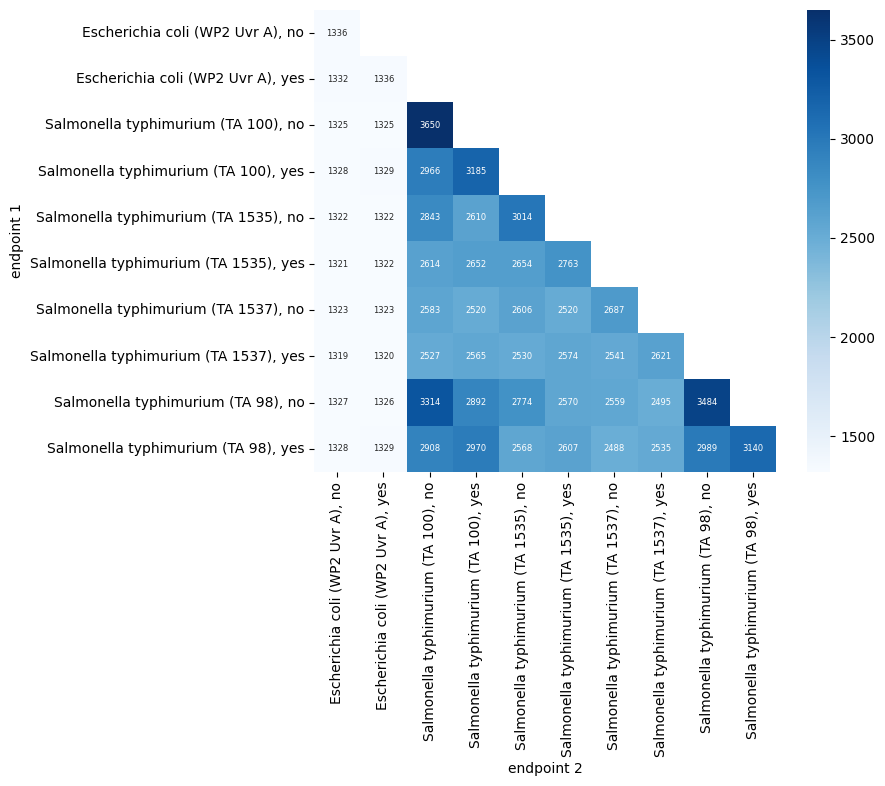

In [45]:
endpoint_pair_data = create_endpoint_pair_data(gentox_data)
create_heatmap(endpoint_pair_data)

The dataset has not been reduced significantly in size. The number of structures is sufficient to attempt fitting a model.

## Structure visualisation and feature generation

Following the dataset preparation and exploration, the next decision we need to take is what kind of features we can use for representing the molecular structures. There are many options, including descriptors like Padel, molecular fingerprints and graph like molecular representations. For the purposes of this training course we will be using Morgan fingerprints generated using rdkit.

Let's create a function to visualise a molecular structure and the available experimental data, and use it for a could of molecular structures in our dataset.

### Molecular structure visualisation

In [46]:
def visualise_molecule(molecule_id, annotate=False):
  '''
  Visualise a molecular structure and the available experimental data
  molecule_id: the molecule ID to visualise
  annotate: if False (default) it will annotate the molecule with the available experimental data. If explicitly set to a string it
  will annotate the molecule using the provided text (useful for when we generate the predictions later on)
  '''
  # select the relevant portion of the dataset
  msk = gentox_data['molecule ID'] == molecule_id
  smiles = gentox_data.loc[msk, 'smiles_std'].iloc[0]
  mol = Chem.MolFromSmiles(smiles)
  # draw the molecule
  img = Draw.MolToImage(mol)
  fig = plt.figure(figsize=(4, 4))
  ax = fig.subplots()
  ax.imshow(img)
  ax.axis('off')
  if not annotate:
    genotoxity_outcome = gentox_data.loc[msk, ['endpoint', 'genotoxicity']].set_index('endpoint').squeeze().to_dict()
    genotoxity_outcome = '\n'.join([f'{k:40s}: {v}' for k, v in genotoxity_outcome.items()])
    genotoxity_outcome
    annotation_text = genotoxity_outcome
  else:
    annotation_text = annotate
  ax.text(2, 300, annotation_text, fontdict={'family': 'monospace', 'size': 8, 'color': 'k'}, verticalalignment='top')  # Annotate
  fig.tight_layout()

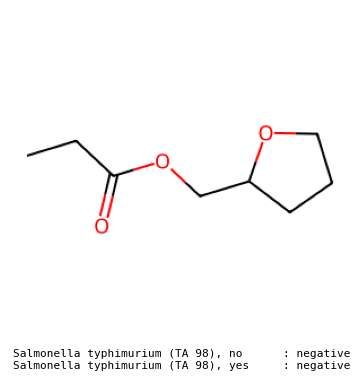

In [47]:
molecule_id = 1000
visualise_molecule(molecule_id)

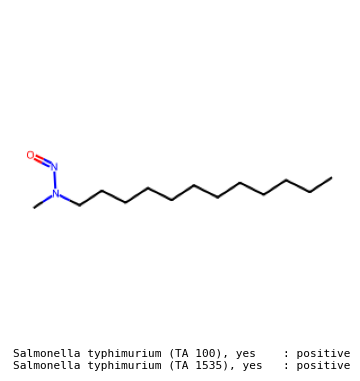

In [48]:
molecule_id = 1200
visualise_molecule(molecule_id)

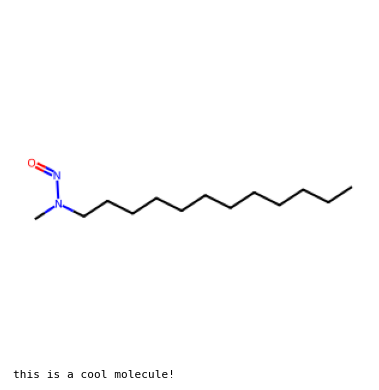

In [49]:
molecule_id = 1200
visualise_molecule(molecule_id, 'this is a cool molecule!')

Let's create an interactive slider to allow the visualisation of a grid with molecules. We can change the number of rows and columns of the grid to show more or fewer molecules.

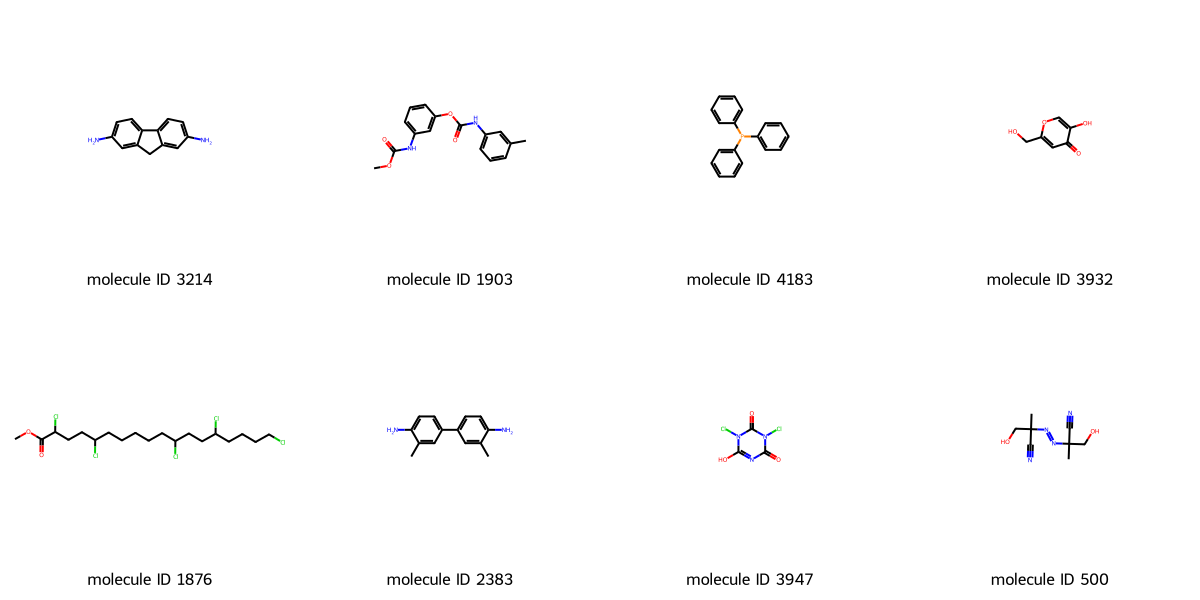

In [50]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from collections import namedtuple

# select how large the grid must be
n_rows = 2
n_cols = 4

# function to generate grid image by randomly drawing molecular structures
def generate_grid(random_state):
  # sample the molecular structures randomly
  tmp = gentox_data[['molecule ID', 'smiles_std']].drop_duplicates().sample(n=n_rows*n_cols, random_state=random_state)
  grid_image = Draw.MolsToGridImage(
      [Chem.MolFromSmiles(smiles) for smiles in tmp['smiles_std']],
      molsPerRow=n_cols,
      subImgSize=(300, 300),  # size of each molecule image
      legends=[f"molecule ID {molecule_id}" for molecule_id in tmp['molecule ID']]  # add legends
  )
  return grid_image

# create a slider widget for going back and forth in the visualization
slider = widgets.IntSlider(
  value=0,  # start at the first set of molecules
  min=0,  # minimum value (first set of molecules)
  max=9,  # maximum value (last set of molecules)
  step=1,
  description='Page:',
  continuous_update=False  # only update on slider release
)
# ceate left and right buttons
left_button = widgets.Button(description="previous")
right_button = widgets.Button(description="next page")
# function to update the slider value when the left button is clicked
def on_left_button_clicked(b):
    if slider.value > slider.min:
        slider.value -= slider.step  # Decrease slider value
# function to update the slider value when the right button is clicked
def on_right_button_clicked(b):
    if slider.value < slider.max:
        slider.value += slider.step  # Increase slider value
# attach the button click events to the respective functions
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# update the image when the slider value changes
def update_image(change):
  # Generate grid image based on the slider value
  grid_image = generate_grid(change.new)
  print(change)
  clear_output(wait=True)
  ui = widgets.HBox([left_button, slider, right_button])
  display(ui)
  display(grid_image)

# attach the update_image function to the slider's value change event
slider.observe(update_image, names='value')

# display the slider and the initial grid image
ui = widgets.HBox([left_button, slider, right_button])
display(ui)
update_image(namedtuple('change', ['new'])(new=0))  # initial image drawing



Are the molecular structures amenable to modelling? Do you observe any structure standardisation issues?

### From smiles to RDKit molecular structures

Smiles are string representations of the molecular structures that cannot be used for cheminformatics operations, such as substructure searches or fingerprint calculations. In this tutorial we are using the cheminformatics package RDKit and hence we will next convert the smiles to RDKit molecules.

In [51]:
# convert the smiles to rdkit molecules
structures = gentox_data[['molecule ID', 'smiles_std']].drop_duplicates().sort_values('molecule ID', ascending=True)
structures['mol'] = structures['smiles_std'].progress_apply(Chem.MolFromSmiles)
structures = structures.set_index('molecule ID')

  0%|          | 0/4236 [00:00<?, ?it/s]

In [52]:
# ensure that all conversions have been successful
structures['mol'].isna().sum()

0

In [53]:
from rdkit import rdBase
# ensure that there are no structure duplicates, given that two different smiles may encode the same structure
rdBase.DisableLog('rdApp.warning') # suppress RDKit warnings
structures['mol'].progress_apply(lambda mol: Chem.MolToInchi(mol, options='-FixedH')).duplicated().sum()

  0%|          | 0/4236 [00:00<?, ?it/s]

0

Typically one would not expect such lack of failures when converting molecular structure formats and when calculating the InChis. This is because the dataset has been carefullly curated for the purposes of this tutorial.

Before we move on to the fingerprint calculation, let's compute the molecular weight distribution to have a feeling of molecular structure size and complexity.

  0%|          | 0/4236 [00:00<?, ?it/s]

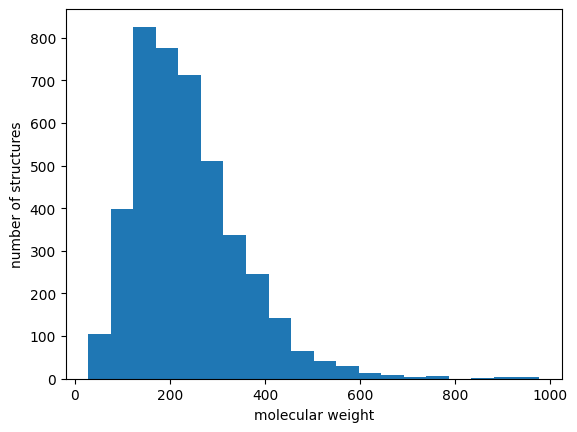

In [54]:
from rdkit.Chem.Descriptors import MolWt
# compute the molecular weight distribution
structures['mol'].progress_apply(MolWt).plot(kind='hist', bins=20, ylabel='number of structures', xlabel='molecular weight');

No molecular structure has molecular weight larger than 1000, which was imposed as a cutoff when the dataset was constructed.

### Fingerprints

In this tutorial we will be using fingerprints for the representation of the molecular structures. There are many variants, but the use of Morgan fingerprints is quite commom. The will be covering the theoretical basis of fingerprints in the lectures. Fingerprints can be of two types, binary and count. The binary fingerprint bits are set to 1 if the corresponding structural moiety is present and 0 if absent, regardless of the number of occurrences in the molecular structure.

Count fingerprints also include the number of occurrences in the molecular structure, without accounting for their relative position. For both binary and count fingerprints we can set the radius and the lengh. The radius reflects the size of he structural moieties assigned to the bits, whilst the length gives the number of bits. There is a tradeoff. If the length is too small bit collisions will be more frequent and detrimental. On the other hand, if the length is too large, the model fitting will take longer and the input vector for each molecule is larger. In addition, most bits will be inactive and it may be harder to train the model even if there is sufficient computing capacity.

We will use binary Morgan fingerprints of radius 2 and of length 1024. In a real life application some more exploration would be needed to optimise the fingerprint parameters, perhaps as part of the hyper parameter tuning that will cover in the second lab.

Let's calculate the fingerprints next.

In [55]:
# set up the fingerprint calculation
fingerprint_parameters = {'radius': 2,
                          'fpSize': 1024,
                          'type': 'count' # 'binary', 'count'
                          }
# create the fingerprint generator
fpgen = AllChem.GetMorganGenerator(radius=fingerprint_parameters['radius'], fpSize=fingerprint_parameters['fpSize'],
                                   countSimulation=False, includeChirality=False)

In [56]:
# define a help function and compute the binary fingerprints
def compute_fingerprint(mol):
  return fpgen.GetFingerprint(mol).ToList()
structures['fingerprint'] = structures['mol'].progress_apply(compute_fingerprint)

  0%|          | 0/4236 [00:00<?, ?it/s]

In [57]:
# check that all fingerprints are lists of fpSize length
np.alltrue(structures['fingerprint'].apply(lambda x: len(x))==fingerprint_parameters['fpSize'])

True

In [59]:
# convert the fingerprints to a numpy array
X = np.array(structures['fingerprint'].to_list())
X

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [60]:
# check how often are the 1024 fingerprint bits active
pd.qcut(X.sum(axis=0), q=np.linspace(0, 1, 11)).value_counts().to_frame().T

,"(5.999, 20.0]","(20.0, 27.0]","(27.0, 32.0]","(32.0, 40.0]","(40.0, 48.0]","(48.0, 60.8]","(60.8, 78.0]","(78.0, 110.0]","(110.0, 194.0]","(194.0, 3163.0]"
count,105,117,88,104,100,100,108,100,100,102


The way to interpret this is as follows:
- 110 bits are only active in less than 38 structures; these bits correponds to rather infrequent structural moieties
- the most frequenty occuring bit is active in 4837 structures out of the 7318 in the dataset
- there are no bits with zero variance, i.e. they are on or off on all structures; such features would not be suitable for modelling

In [61]:
# check how dense are the fingerprints
pd.qcut(X.sum(axis=1), q=np.linspace(0, 1, 11)).value_counts().to_frame().T

,"(1.999, 12.0]","(12.0, 16.0]","(16.0, 19.0]","(19.0, 22.0]","(22.0, 24.0]","(24.0, 27.0]","(27.0, 31.0]","(31.0, 36.0]","(36.0, 45.0]","(45.0, 83.0]"
count,455,451,434,466,325,450,442,375,452,386


No molecular structure has more than 86 bits active. This is indicative of relatively simple compounds with few functional groups each. On the other hand there is at least one structure with only 2 bits active. Can you guess how simple could this structure be?

Lets visualise the molecular structure with most and least active bits.

83 active bits


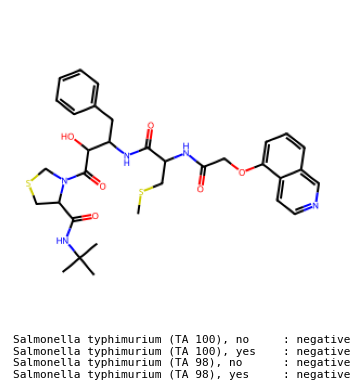

In [62]:
# visualise the most complex molecular structure
idx_max = X.sum(axis=1).argmax()
molecule_id = structures.iloc[idx_max].name # remember that we removed ambiguous genotoxicity calls and molecule IDs are not continuous anymore
print(f"{X.sum(axis=1).max()} active bits")
visualise_molecule(molecule_id)

2 active bits


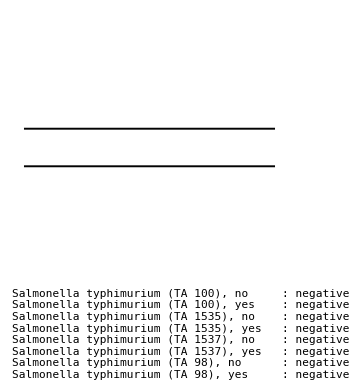

In [63]:
# visualise the least complex molecular structure
idx_max = X.sum(axis=1).argmin()
molecule_id = structures.iloc[idx_max].name # remember that we removed ambiguous genotoxicity calls and molecule IDs are not continuous anymore
print(f"{X.sum(axis=1).min()} active bits")
visualise_molecule(molecule_id);

### Structural similarity vs biological activity

As one final sanity check, let's use the calculated fingerprints to identify structurally similar molecular structures with different genotoxicity outcomes.

The fingerprints are binary vectors and their Jaccard similarity can be computed using
$$J\left(A,B\right) = \frac{\left|A∪B\right|}{\left|A∩B\right|}$$
The Jaccard distance is 1 - Jaccard similarity.

Computing the distance (or similarity) between all structural pairs is computationally intensive and hence the next cell may take a couple of minutes to execute.

In [64]:
# calculate Jaccard distances
from scipy.spatial.distance import pdist, squareform
jaccard_distances = pdist(X, metric="jaccard")
jaccard_matrix = squareform(jaccard_distances)

We will now visualise the Jaccard similarities using a heatmap and a histogram. Note that the heatmap is limited to 200 structures otherwise it will take too long and it will not be legible.

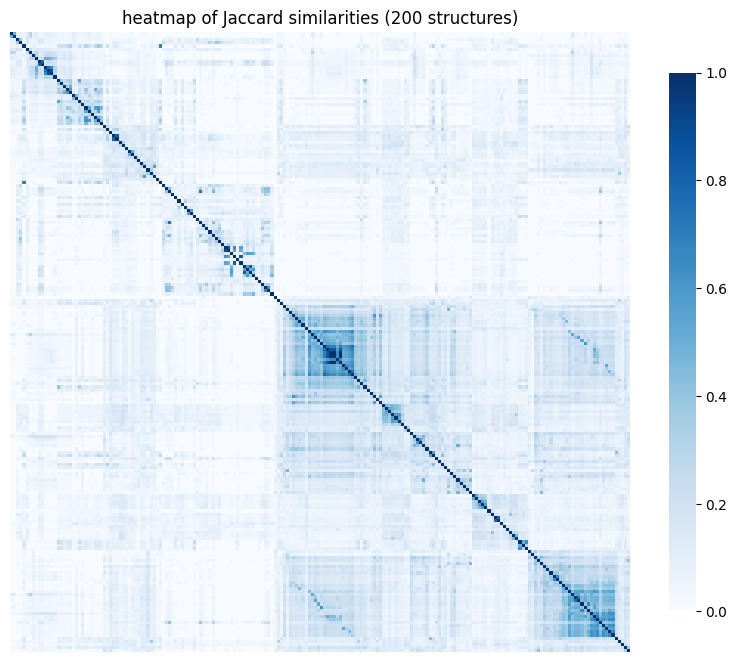

In [65]:
# visualise (small part of!) the Jaccard similarities as a heatmap
from matplotlib import gridspec
n_structures_sample = 200
fig = plt.figure(figsize=(10, 10))
ax = fig.subplots()
sns.heatmap(1.-jaccard_matrix[:n_structures_sample, :n_structures_sample], annot=False, cmap='Blues', square=True, cbar_kws={'shrink': 0.7}, ax=ax)
ax.axis('off')
ax.set_title(f"heatmap of Jaccard similarities ({n_structures_sample} structures)");

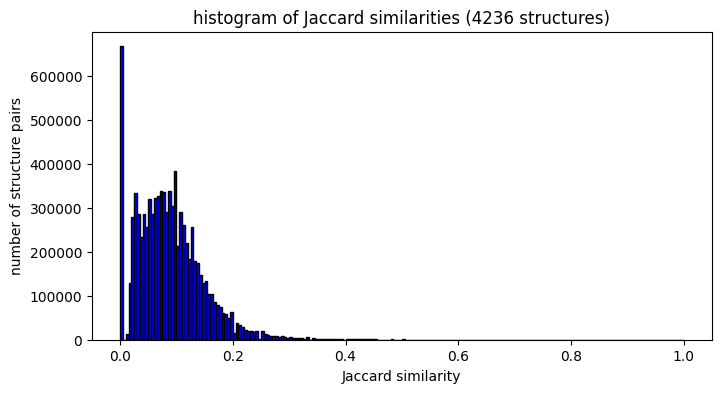

In [66]:
# visualise Jaccard similarities as a histogram
fig = plt.figure(figsize=(8, 4))
ax = fig.subplots()
ax.hist(1.-jaccard_distances, bins=200, color="blue", edgecolor="black")
ax.set_title(f"histogram of Jaccard similarities ({X.shape[0]} structures)")
ax.set_xlabel("Jaccard similarity")
ax.set_ylabel("number of structure pairs");

We will now identify some structure pairs with small distance and for which the available genotoxicity data differ. Lets first put together the indices of the molecular structure pairs with the corresponding Jaccard distance. This calculation will take a minute or so.

In [67]:
# get all structure pairs with their distances
num_structures = X.shape[0]
pairs = [(i, j) for i in range(num_structures) for j in range(i+1, num_structures)]
pairs_and_distances = sorted(zip(pairs, list(jaccard_distances)), key=lambda x: x[1])
del jaccard_distances, jaccard_matrix

In [68]:
# identify few suspicious pairs with small distances and different genotoxicity outcomes
n_suspicious_pairs = 20
suspicious_pairs = []
for pair, dist in pairs_and_distances:
  molecule_id1 = structures.iloc[pair[0]].name
  molecule_id2 = structures.iloc[pair[1]].name
  genotoxicity1 = gentox_data.loc[gentox_data['molecule ID'] == molecule_id1, ['endpoint', 'genotoxicity']].set_index('endpoint').iloc[:,0].rename(f'Molecule ID {molecule_id1}')
  genotoxicity2 = gentox_data.loc[gentox_data['molecule ID'] == molecule_id2, ['endpoint', 'genotoxicity']].set_index('endpoint').iloc[:,0].rename(f'Molecule ID {molecule_id2}')
  genotoxicity = pd.concat([genotoxicity1, genotoxicity2], axis=1)
  genotoxicity_differs = genotoxicity[f'Molecule ID {molecule_id1}'].notnull() & genotoxicity[f'Molecule ID {molecule_id2}'].notnull() & (genotoxicity[f'Molecule ID {molecule_id1}'] != genotoxicity[f'Molecule ID {molecule_id2}'])
  if (not genotoxicity.empty) & genotoxicity_differs.any():
    suspicious_pairs.append((pair, dist, genotoxicity.dropna(how='any', axis='index')))
    if len(suspicious_pairs) >= n_suspicious_pairs:
      break
del pairs_and_distances

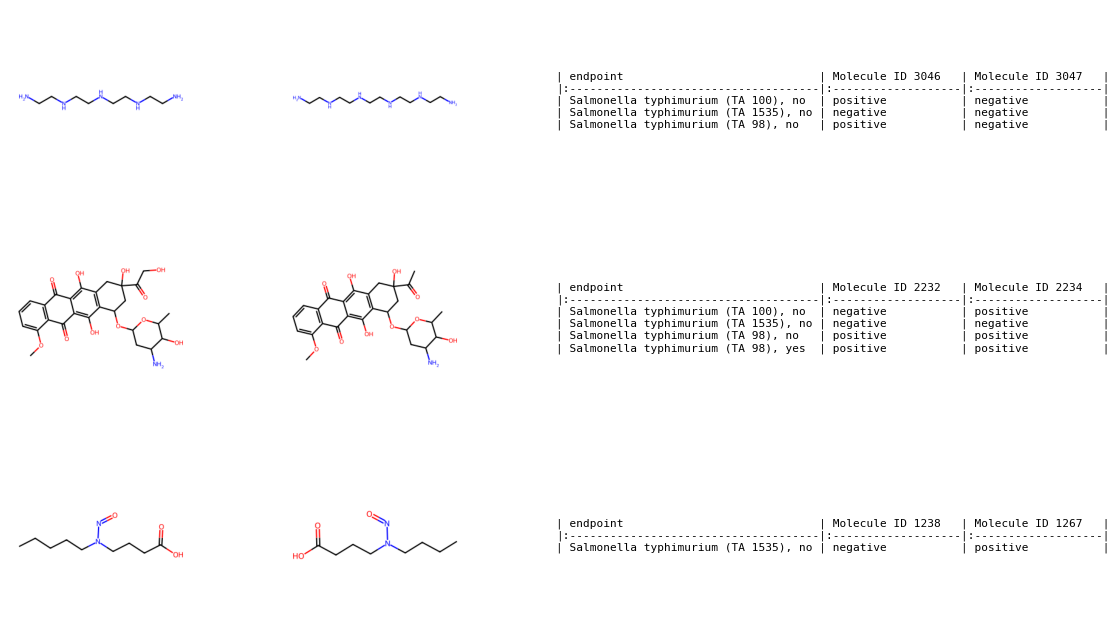

In [69]:
# visualise few of the suspicious pairs
n_pairs_to_show = 3
import random
random.seed(1)
idxs = random.choices(range(n_suspicious_pairs), k=n_pairs_to_show)
fig = plt.figure(figsize=(10, 8))
axs = fig.subplots(ncols=3, nrows=n_pairs_to_show)
for i, idx in enumerate(idxs):
  (pair, dist, genotoxicity) = suspicious_pairs[idx]
  molecule_id1 = structures.iloc[pair[0]].name
  molecule_id2 = structures.iloc[pair[1]].name
  img1 = Draw.MolToImage(structures.loc[molecule_id1, 'mol'])
  img2 = Draw.MolToImage(structures.loc[molecule_id2, 'mol'])
  axs[i, 0].imshow(img1)
  axs[i, 0].axis('off')
  axs[i, 1].imshow(img2)
  axs[i, 1].axis('off')
  axs[i, 2].text(0.1, 0.5, genotoxicity.to_markdown(), fontdict={'family': 'monospace', 'size': 8, 'color': 'k'}, verticalalignment='center')
  axs[i, 2].axis('off')

What could cause such suspicious/conflicting genotoxicity outcomes and what would we need to do to check and, if needed, improve the quality of the data?

For the purposes of this tutorial we will keep the dataset as is without further investigations. The hope is that statistically the model will be able to ignore conflicting evidence, perhaps by predicting a positive probability close to the 0.5 threshold, without compromising significantly its predictive performance.

Developing a model in real life will need to have such suspicious/conflicting data points verified. Most of the times the effort needed for data curation  exceeds the effort for building a model. Computational insights can help accelerate the data curation.

A few questions pop to mind:
- is there merit in using our framework contract for data curation?
- could we use the model predictions to identify likely erroneous data points?
- which endpoints could we start with?

## Model building

This section focuses on building classification models for predicting the probability of substance to cause gene mutation in bacteria.

The lectures provided an overview of different model architectures that can be used. In this tutorial we will be using feed forward neural networks, that is likely the simplest form of deep learning with practical applications.

Building and validating a model requires several steps. Usually the first step is to use all available data to ensure that the model fitting converges.

### Feed forward neural network (FFNN)

The following code block defines a class to initialise FFNN models. Models can be initialised by choosing the number of hidden layers and number of neurons in each, the dropout to regulate overfitting and the activation function to introduce the necessary non-linearity in the model. The model can be used for both single and multitask models, as well as binary and multiclass classification problems. For simplicty we will be using this class for building a single task, binary classifier, for example for predicting the probability of having a positive outcome in Salmonell thyphimurium TA 100 with metabolic activation (S9+).

Some of these neural network hyperparameters have been covered in the lecture, but without going into all details. What is important to keep in mind is that we need to make many choices and usually one starts with the simpler, smaller models before attempting using more complex ones. This is the principle of parsimony, also known as Occam's razor (https://en.wikipedia.org/wiki/Occam%27s_razor).


#### Model architecture

In [70]:
from typing import Callable
class FFNNModel(torch.nn.Module):

    def __init__(self,
                 n_input: int,
                 hidden_layers: list[int],
                 dropout: float,
                 n_classes: [int],
                 activation_function: Callable = torch.nn.functional.leaky_relu):
        '''
        Implements a simple feedforward neural network in PyTorch.
        It can be used for both simple and multitask models.

        The model is initialised with the following parameters:
        :param n_input: number of input features (fingerprint length)
        :param hidden_layers: array with the number of neurons in each hidden layer
        :param dropout: dropout rate
        :param n_classes: number of output classes
        :param activation_function: PyTorch activation function, e.g. torch.nn.functional.relu or torch.nn.functional.leaky_relu
        '''
        super().__init__()


        # general parameters
        self.dropout = dropout
        self.hidden_layers = hidden_layers
        self.activation_function = activation_function
        self.n_classes = n_classes

        # set up the linear layers
        self.linear_layers = torch.nn.ModuleList()
        self.linear_layers.append(torch.nn.Linear(n_input, self.hidden_layers[0]))
        for i in range(len(self.hidden_layers)-1):
            self.linear_layers.append(torch.nn.Linear(self.hidden_layers[i], self.hidden_layers[i+1]))

        # set up the output layers, one for each task
        self.out_layers = torch.nn.ModuleList()
        for n_class in self.n_classes:
            self.out_layers.append(torch.nn.Linear(self.hidden_layers[-1], n_class))

        # dropout layer
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, task_id: int):

        # apply the linear layers, dropout after activation
        for module in self.linear_layers:
            x = self.activation_function(module(x))
            x = self.dropout(x)

        # apply the output layer (classification, produces logits)
        output = self.out_layers[task_id](x)
        return output

#### Making predictions

We will next initialise a model and use it for making a prediction. The model has not been fitted yet and hence it has randomly initialised weights and biases. We assume that the input vector is a vector with 1024 floats, that is consistent with our choice of Morgan fingerprints.

We will feed in a set of two random fingerprints corresponding to two fictitious molecular structures.

In [71]:
# set the seed for deterministic behaviour
torch.manual_seed(1)
# define the model and set it to inference mode
net = FFNNModel(n_input=1024, hidden_layers=[128, 128], dropout=0.2, n_classes=[2])
net.eval()
# create a set of random fingerprints
X_tensor = torch.randint(0, 2, (2, 1024), dtype=torch.float32)
# predict the logits for a negative and a positive prediction
y_pred_logits = net(X_tensor, task_id=0)
# predict the probabilities for a negative a positive prediction using softmax
y_pred_prob = pd.DataFrame(F.softmax(y_pred_logits, dim=1).detach().cpu().numpy(),
                           columns=['negative (probability)', 'positive (probability)'])
y_pred_prob

,negative (probability),positive (probability)
0,0.491,0.509
1,0.486,0.514


We can now use this model to predict the genotoxicity outcome for all substances in the dataset.

We first focus on structures for which we have experimental data for Salmonella typhimurium TA 100 S9+.

We had previously generated an array with the fingerpints for all structures in the dataset. We will be using the fingerprints for those structures with TA 100 S+ data available.

In [72]:
# keep the molecular structures with experimental data for TA 100 S9+
msk = gentox_data['endpoint'] == 'Salmonella typhimurium (TA 100), yes'
tmp = gentox_data.loc[msk]
print(f"There are {len(tmp)} structures with TA 100 S9+ genotoxicity data")
X = structures.loc[tmp['molecule ID'].tolist(), 'fingerprint']
y = tmp['genotoxicity']
# create a tensor and make predictions
X_tensor = torch.tensor(np.array(X.to_list()), dtype=torch.float32)
net.eval()
y_pred_logits = net(X_tensor, task_id=0)
y_pred_prob = pd.DataFrame(F.softmax(y_pred_logits, dim=1).detach().cpu().numpy(),
                           columns=['negative (probability)', 'positive (probability)'])
y_pred = np.where(y_pred_prob['positive (probability)'] > 0.5, 'positive', 'negative')
np.concatenate([y_pred_prob, y_pred.reshape(-1, 1)], axis=1)

There are 3185 structures with TA 100 S9+ genotoxicity data


array([['0.49003023', '0.50996983', 'positive'],
       ['0.49807054', '0.50192946', 'positive'],
       ['0.4942407', '0.5057593', 'positive'],
       ...,
       ['0.4898895', '0.51011056', 'positive'],
       ['0.49598137', '0.50401866', 'positive'],
       ['0.4944394', '0.5055606', 'positive']], dtype='<U32')

How well do you think that this model can predict the experimental TA 100 S9+ genotoxicity outcomes? The lecture covered several of the typically used performance metrics for both regression and classification problems like this one.

For the purposes of this tutorial we will be using the following predictive performance metrics:
- sensitivity
- specificity
- balanced accuracy
- area under the curve (AUC)

In [73]:
# predictive performance metrics
sensitivity  = recall_score(y, y_pred, pos_label='positive')
specificity  = recall_score(y, y_pred, pos_label='negative')
balanced_accuracy = balanced_accuracy_score(y, y_pred)
roc_auc = roc_auc_score(y.map({'positive': 1, 'negative': 0}), y_pred_prob['positive (probability)'].values)
print(f"sensitivity: {sensitivity:.2f}")
print(f"specificity: {specificity:.2f}")
print(f"balanced accuracy: {balanced_accuracy:.2f}")
print(f"AUC: {roc_auc:.2f}")

sensitivity: 0.96
specificity: 0.04
balanced accuracy: 0.50
AUC: 0.50


The predictive performance is as expected poor given that the experimental data have not been used for adjusting the model weights and biases.

We have progressed a long way already though. We can now define and initialise a FFNN model and we can use it for making predictions. We will now proceed with the training of the model.

#### Model training

Training a model essentially boils down to be an optimisation problem. The model weights are biases are adjusted so that the objective function, known as loss function in machine learning, is minimised. The loss function used for this tutorial is cross entropy.



Model training is an iterative process. For each iteration, known as epoch in deep learning, we partition the training set into batches and iterate over these as well. For every batch we compute the loss function and its derivatives with regard to the model weights and biases (model parameters). The model parameters are adjusted and the iterations continue until no further progress can be made.

Before we continue we need to look after a critical aspect. Is the dataset balanced, i.e. do we have the same number of positives and negatives?





In [74]:
# check if the dataset is balanced
y.value_counts()

,count
genotoxicity,
negative,2253
positive,932


The dataset is not balanced. There are 2 times more negatives than positives. Hence it is expected that the model will learn more effectively how to predict negatives than positives, which may not be ideal depending on how we wish to use the model (for prioritisation or deprioritisation). We will come back to this point later.

Let's proceed with a first model training attempt. We will create a dataset that will be fed into a dataloader that will be used for splitting the data into batches.

In [99]:
# create the dataset
dset = TensorDataset(torch.tensor(np.stack(X.values, axis=0), dtype=torch.float32), torch.tensor(y.map({'positive': 1, 'negative': 0}).values, dtype=torch.long))

In [100]:
# set up the model
from copy import deepcopy
net = FFNNModel(n_input=1024, hidden_layers=[128, 128], dropout=0.2, n_classes=[2])
# we keep a copy of the weights to be able to reinitialise the model to the same parameters
model_parameters = deepcopy(net.state_dict())
n_parameters = sum([np.prod(v.size()) for k, v in model_parameters.items()])
print(f"The model has {n_parameters} parameters")

The model has 147970 parameters


Can you work out the number of model parameters based on the model architecture?

Hint:
- first layer has 1024*128 weights and 128 biases
- second layer has 128*128 weights and 128 biases
- classification layer has 128*2 weights and 2 biases

This is a phenomenal number of parameters for ~3000 substances in the training set. To put things in perspective, chat GPT 3 had 180 billion parameters, i.e. it was 1200 times larger!

In [101]:
# set up the loss function
weights = torch.tensor([1., 1.])
loss_fn = torch.nn.CrossEntropyLoss(weight=weights)

In [102]:
# train the model
def train_model(dset, model_parameters):
  # set the seed for deterministic behaviour
  torch.manual_seed(1)
  # set up the optimiser
  optimiser = torch.optim.Adam(net.parameters(), lr=0.001,
                             betas=[0.9, 0.999], eps=1e-08,
                             weight_decay=1.e-6, amsgrad=False)
  # create the dataloader
  batch_size = 512
  dataloader = DataLoader(dset, batch_size=batch_size, shuffle=True, drop_last=True)
  net.load_state_dict(model_parameters)
  num_epochs = 10
  net.train()
  loss_history = []
  for epoch in tqdm(range(num_epochs)):
    for i_batch, (X_batch, y_batch) in enumerate(dataloader):
      optimiser.zero_grad()
      logits = net(X_batch, task_id=0)
      loss = loss_fn(logits, y_batch)
      loss_history.append({'epoch': epoch, 'batch': i_batch, 'loss': loss.item()})
      loss.backward()
      optimiser.step()
  loss_history = pd.DataFrame(loss_history)
  return loss_history
loss_history = train_model(dset, model_parameters)

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0, 0.5, 'loss')

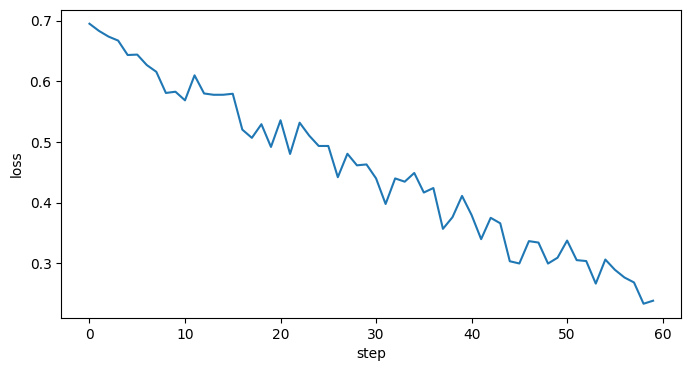

In [103]:
# visualise the loss convergence
fig = plt.figure(figsize=(8, 4))
ax = fig.subplots()
ax.plot(loss_history['loss'])
ax.set_xlabel('step')
ax.set_ylabel('loss')

The loss seems to converge. Let's compute the predictive performance metrics once more.

In [104]:
# generate the predictions
net.eval()
y_pred_logits = net(X_tensor, task_id=0)
y_pred_prob = pd.DataFrame(F.softmax(y_pred_logits, dim=1).detach().cpu().numpy(),
                           columns=['negative (probability)', 'positive (probability)'])
y_pred = np.where(y_pred_prob['positive (probability)'] > 0.5, 'positive', 'negative')
# predictive performance metrics
sensitivity  = recall_score(y, y_pred, pos_label='positive')
specificity  = recall_score(y, y_pred, pos_label='negative')
balanced_accuracy = balanced_accuracy_score(y, y_pred)
roc_auc = roc_auc_score(y.map({'positive': 1, 'negative': 0}), y_pred_prob['positive (probability)'].values)
print(f"sensitivity: {sensitivity:.3f}")
print(f"specificity: {specificity:.3f}")
print(f"balanced accuracy: {balanced_accuracy:.3f}")
print(f"AUC: {roc_auc:.3f}")

sensitivity: 0.840
specificity: 0.933
balanced accuracy: 0.887
AUC: 0.959


The predictive performance of the model appears to be extremely good. In only 10 epochs, sensitivity and specificity exceed 80%, although the exact values of the metrics may sligthly differ with your model given the stochastic nature of the parameter initialisation. Please also note that the specificity is better than sensitivity that can be attributed to the dataset imbalance.

But is the model really so good as these performance metrics indicate?

#### Train/test split

So far we used the same dataset for training the model and for evaluating its predictive performance. This is a flawed approach that may give an overly optimistic picture of the true predictive performance. When the model is used for new structures the predictive performance may be poor. The lecture covered the concepts of under- and overfitting and how these can be detected and avoided.

The simplest approach to avoid overfitting is to split the dataset into a training set (80% of the available data) and an evaluation set (20% of the available data, image from https://doi.org/10.48550/arXiv.1811.12808).

We will now repeat the model training by splitting the dataset in this way.

Note: How do we know how many epochs are needed? Typically the evaluation set is used for this purpose. We choose a performance metric, such as balanced accuracy or the F1 score, and for each epoch we compute this performance metric for the evaluation set. If no progress has been made in the last few epochs training can be stopped. In order to keep things simple, we will simply run a small predefined number of epochs without such early stopping mechanism.

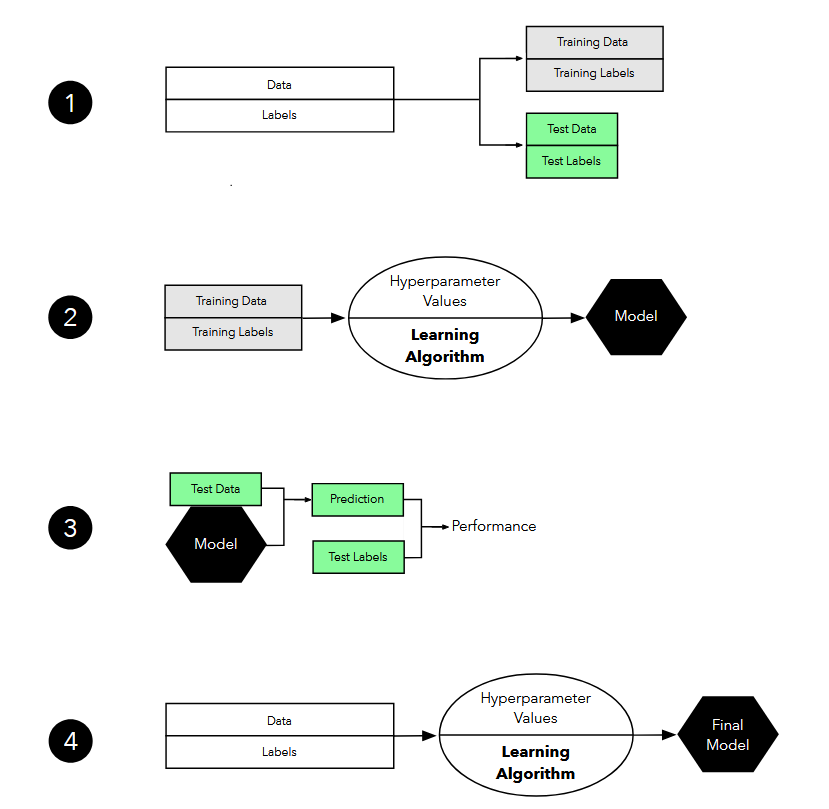

In [143]:
# keep the molecular structures with experimental data for TA 100 S9+
msk = gentox_data['endpoint'] == 'Salmonella typhimurium (TA 100), yes'
tmp = gentox_data.loc[msk]
X = structures.loc[tmp['molecule ID'].tolist(), 'fingerprint']
y = tmp['genotoxicity']

# split the dataset set into training and evaluation using stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
print(f"Training will use {len(X_train)} structures out of {len(tmp)} structures with TA 100 S9+ genotoxicity data")
print(f"{len(X_test)} structures will be used to compute the performance metrics and assess the model generalisation ability")

# create the dataset
dset = TensorDataset(torch.tensor(np.stack(X_train, axis=0), dtype=torch.float32), torch.tensor(y_train.map({'positive': 1, 'negative': 0}).values, dtype=torch.long))

Training will use 2548 structures out of 3185 structures with TA 100 S9+ genotoxicity data
637 structures will be used to compute the performance metrics and assess the model generalisation ability


In [107]:
# train the model using the previously created function
loss_history = train_model(dset, model_parameters)

  0%|          | 0/10 [00:00<?, ?it/s]

In [108]:
# generate predictions for the training and evaluation set
net.eval()
for typ, (X, y) in {'train': (X_train, y_train), 'evaluation': (X_test, y_test)}.items():
  X_tensor = torch.tensor(np.array(X.to_list()), dtype=torch.float32)
  y_pred_logits = net(X_tensor, task_id=0)
  y_pred_prob = pd.DataFrame(F.softmax(y_pred_logits, dim=1).detach().cpu().numpy(),
                            columns=['negative (probability)', 'positive (probability)'])
  y_pred = np.where(y_pred_prob['positive (probability)'] > 0.5, 'positive', 'negative')
  # predictive performance metrics
  sensitivity  = recall_score(y, y_pred, pos_label='positive')
  specificity  = recall_score(y, y_pred, pos_label='negative')
  balanced_accuracy = balanced_accuracy_score(y, y_pred)
  roc_auc = roc_auc_score(y.map({'positive': 1, 'negative': 0}), y_pred_prob['positive (probability)'].values)
  print(f"sensitivity ({typ}): {sensitivity:.3f}")
  print(f"specificity ({typ}): {specificity:.3f}")
  print(f"balanced accuracy ({typ}): {balanced_accuracy:.3f}")
  print(f"AUC ({typ}): {roc_auc:.3f}\n")

sensitivity (train): 0.718
specificity (train): 0.928
balanced accuracy (train): 0.823
AUC (train): 0.920

sensitivity (evaluation): 0.581
specificity (evaluation): 0.898
balanced accuracy (evaluation): 0.739
AUC (evaluation): 0.832



The true predictive power of the model is in reality much worse than what we originally thought. The difference between sensitivity and specificity is now even greater for the evaluation set.

We have seen that using the same training set for fitting the model and for estimating the predictive performance is heavily optimistically biased. On the other hand, if we withhold a significant part of the data for evaluation of the predictive performance we may get a pessimistically biased estimate. This is because the model would have improved if trained with more data assuming that it has not reached its capacity. On the other hand, keeping too few datapoints for evaluating the predictive performance could increase its variance. This interplay between variance and bias is a common theme in this area of work. You may hear the expressions "there is no free lunch" and "find the sweet spot" quite often. In practice, there are also better ways to split the available data, .e.g. based on k-fold cross validation, as discussed in the lecture.

#### Handle imbalance

Before we conclude this lab session we will sligthly modify the loss function by giving more weight to the positives and repeat the training and evaluation as before.

In [109]:
# set up the loss function, this time giving more weight to the positives
weights = torch.tensor([1., 4.])
weights = weights/weights.norm()
loss_fn = torch.nn.CrossEntropyLoss(weight=weights)

In [110]:
# train the model using the previously created function
loss_history = train_model(dset, model_parameters)

  0%|          | 0/10 [00:00<?, ?it/s]

In [111]:
# generate predictions for the training and evaluation set
net.eval()
for typ, (X, y) in {'train': (X_train, y_train), 'evaluation': (X_test, y_test)}.items():
  X_tensor = torch.tensor(np.array(X.to_list()), dtype=torch.float32)
  y_pred_logits = net(X_tensor, task_id=0)
  y_pred_prob = pd.DataFrame(F.softmax(y_pred_logits, dim=1).detach().cpu().numpy(),
                            columns=['negative (probability)', 'positive (probability)'])
  y_pred = np.where(y_pred_prob['positive (probability)'] > 0.5, 'positive', 'negative')
  # predictive performance metrics
  sensitivity  = recall_score(y, y_pred, pos_label='positive')
  specificity  = recall_score(y, y_pred, pos_label='negative')
  balanced_accuracy = balanced_accuracy_score(y, y_pred)
  roc_auc = roc_auc_score(y.map({'positive': 1, 'negative': 0}), y_pred_prob['positive (probability)'].values)
  print(f"sensitivity ({typ}): {sensitivity:.3f}")
  print(f"specificity ({typ}): {specificity:.3f}")
  print(f"balanced accuracy ({typ}): {balanced_accuracy:.3f}")
  print(f"AUC ({typ}): {roc_auc:.3f}\n")

sensitivity (train): 0.926
specificity (train): 0.814
balanced accuracy (train): 0.870
AUC (train): 0.942

sensitivity (evaluation): 0.747
specificity (evaluation): 0.785
balanced accuracy (evaluation): 0.766
AUC (evaluation): 0.837



The difference between sensitivity and specificity has been reduced. Overall, it seems that with a relatively simple model we managed to achieve balanced accuracy of around 80% that is not bad. However, do not forget the effort that went into the dataset preparation. The quality of the data is almost always what matters most.